## <center> Проект по курсу "Интеллектуальный анализ данных"
## <center>  Прогнозирование популярности статей на Хабре 
###### Выполнили: 
* _Осина Анна_ ИАД-2
* _Пляскин Павел_  ИАД-2
                        

**Описание соревнования**

Задача заключается в предсказании количества звездочек, которые наберет статья, опубликованная на Хабре, по ее содержанию и времени публикации. Количество звездочек – это количество пользователей, которые добавили данную статью в раздел «избранное». Другими словами, количество звездочек определяет популярность статьи.

**Целевая переменная **

Целевой переменной является _favs_ _lognorm_ - это переменная, которая показывает долю статей, у которых звездочек меньше, чем у текущей.

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy

import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

import brewer2mpl
dark2_colors = brewer2mpl.get_map('Paired', 'Qualitative', 10).mpl_colors

import warnings
warnings.filterwarnings('ignore')

sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

In [2]:
train_df = pd.read_csv('howpop_train.csv')
test_df  = pd.read_csv('howpop_test.csv')

In [3]:
train_df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


**Описание признаков**

* _url_ – единый указатель ресурса domain – домен
* _post_id_ – номер поста published – время публикации author – автор
* _flow_ – тема статьи
* _polling_ – есть ли опрос в статье content_len – длина контента
* _title_ – название
* _comments_ – комментарии
* _favs_ – избранное
* _views_ – просмотры
* _votes_plus_ – количество плюсов votes_minus – количество минусов views_lognorm – доля статей, у которых просмотров меньше, чем у текущей
* _favs_lognorm_ – доля статей, у которых звездочек меньше, чем у текущей
* _comments_lognorm_ – доля статей, у которых комментариев меньше, чем у текущей

Для объектов из тестовой выборки мы не будем знать значения никаких показателей популярности: 
* _views_
* _favs_
* _comments_
* _votes_ _plus_
* _votes_ _minus_
* _views_ _lognorm_
* _comments_ _lognorm_ 

и, соответственно, значение целевой переменной _favs_lognorm_.

** Число объектов в обучающей и тестовой выборках: **

In [4]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

** Проверим наличие незаполненных данных **

In [5]:
train_df.isnull().mean()

url                 0.000000
domain              0.000000
post_id             0.000000
published           0.000000
author              0.271961
flow                0.276501
polling             0.000000
content_len         0.000000
title               0.000000
comments            0.000000
favs                0.000000
views               0.000000
votes_plus          0.004257
votes_minus         0.004257
views_lognorm       0.000000
favs_lognorm        0.000000
comments_lognorm    0.000000
dtype: float64

In [6]:
test_df.isnull().mean()

url            0.000000
domain         0.000000
post_id        0.000000
published      0.000000
author         0.402005
flow           0.331328
polling        0.000000
content_len    0.000000
title          0.000000
dtype: float64

Оказывается, в данных существуют пропуски. Заполним их.

In [7]:
categorial = ['author', 'flow', 'domain', 'title']
test_df[categorial][:5]

,author,flow,domain,title
0,@fsou11,develop,habrahabr.ru,Опыт использования MassTransit 3.0
1,NaN,marketing,habrahabr.ru,Геймификация форума на движке XenForo
2,NaN,admin,habrahabr.ru,Кластер высокой доступности на postgresql 9.6 ...
3,NaN,develop,habrahabr.ru,Как перестать бояться и полюбить синтаксически...
4,NaN,NaN,geektimes.ru,Мифы и реальность: Что нужно знать о современн...


In [8]:
train_df.flow = train_df.flow.fillna('unknown')
train_df.author = train_df.author.fillna('unknown')

test_df.flow = test_df.flow.fillna('unknown')
test_df.author = test_df.author.fillna('unknown')

** Посмотрим на стандартные показатели для каждого признака **

In [9]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.000000,115565.000000,182666.000000,257401.000000,3.140880e+05
content_len,134137.0,7516.929699,8724.771640,1.000000,2179.000000,4949.000000,9858.000000,3.524710e+05
comments,134137.0,39.625994,62.398958,0.000000,7.000000,19.000000,48.000000,2.266000e+03
favs,134137.0,71.999866,145.854135,0.000000,8.000000,27.000000,78.000000,8.718000e+03
views,134137.0,16631.013084,31479.819691,3.000000,2100.000000,7600.000000,18700.000000,1.730000e+06
votes_plus,133566.0,35.536888,42.461073,0.000000,11.000000,22.000000,45.000000,1.466000e+03
votes_minus,133566.0,8.050035,11.398282,0.000000,2.000000,5.000000,10.000000,4.450000e+02
views_lognorm,134137.0,0.004849,1.002158,-6.615254,-0.706552,-0.020934,0.682689,5.182821e+00
favs_lognorm,134137.0,0.003402,1.002778,-4.137662,-0.695780,0.007022,0.708778,4.872866e+00
comments_lognorm,134137.0,-0.003675,1.005259,-4.161967,-0.633775,0.072082,0.697072,3.900973e+00


** Бинарные и категориальные переменные **

In [10]:
train_df.describe(include = ['object', 'bool']).T

,count,unique,top,freq
url,134137,134137,https://habrahabr.ru/post/202904/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,134137,22078,unknown,36480
flow,134137,7,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [11]:
dict_for_polling = {False : 0, True : 1}
train_df.polling = train_df.polling.map(dict_for_polling)

#### Убедимся, что данные отсортированы по признаку `published`

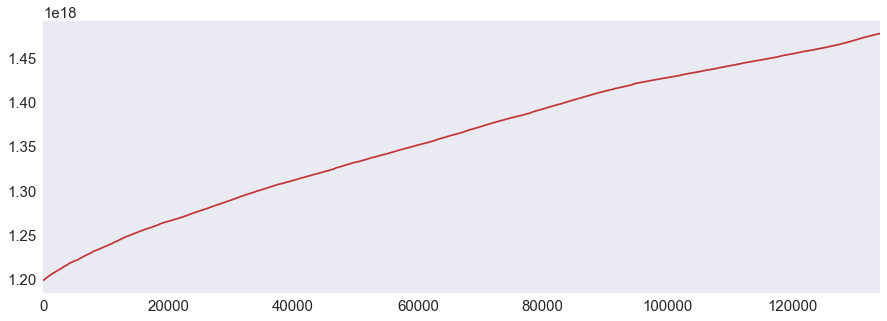

In [12]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot();

Мы видим как дата публикации постов в наборе данных монотонно возрастает, а значит они действительно отсортированы по дате.

#### Проверим, есть ли коррелирующие признаки:

In [13]:
names_for_corr = train_df[train_df.columns]
corr_ = names_for_corr.corr()
corr_

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1.000000,0.081628,0.241384,-0.147763,0.089313,0.132385,-0.187885,-0.235594,-0.010376,-0.005845,-0.001605
polling,0.081628,1.000000,-0.003337,0.042605,0.006882,0.025660,-0.033505,0.027116,-0.003523,-0.036385,0.071417
content_len,0.241384,-0.003337,1.000000,-0.023544,0.308194,0.204101,0.068779,-0.078686,0.246063,0.356481,0.073132
comments,-0.147763,0.042605,-0.023544,1.000000,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.662740
favs,0.089313,0.006882,0.308194,0.164166,1.000000,0.634304,0.416241,0.062877,0.456097,0.587982,0.263239
views,0.132385,0.025660,0.204101,0.290035,0.634304,1.000000,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.033505,0.068779,0.613961,0.416241,0.396849,1.000000,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.027116,-0.078686,0.457638,0.062877,0.128654,0.464168,1.000000,0.146609,0.088226,0.355458
views_lognorm,-0.010376,-0.003523,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1.000000,0.688811,0.546530
favs_lognorm,-0.005845,-0.036385,0.356481,0.278942,0.587982,0.406782,0.449712,0.088226,0.688811,1.000000,0.479476


In [14]:
[abs(i) for i in np.array(train_df.corr()).flatten() if (i>0.8)&(i<1)]

[]

Признаков, которые сильно коррелируют между собой, не найдено.

#### Столбец published (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу datetime:

In [15]:
print(train_df.published.dtype)
train_df['published'] = pd.to_datetime(train_df.published, yearfirst = True)
print(train_df.published.dtype)

object
datetime64[ns]


In [16]:
print(test_df.published.dtype)
test_df['published'] = pd.to_datetime(test_df.published, yearfirst = True)
print(test_df.published.dtype)

object
datetime64[ns]


#### Создадим несколько столбцов на основе данных о времени публикации:

In [17]:
train_df['published'] = pd.to_datetime(train_df.published, yearfirst = True)
test_df['published'] = pd.to_datetime(test_df.published, yearfirst = True)

train_df['year'] = [d.year for d in train_df.published]
test_df['year'] = [d.year for d in test_df.published]


train_df['month'] = [d.month for d in train_df.published]
test_df['month'] = [d.month for d in test_df.published]

train_df['week_of_day'] = [d.isoweekday() for d in train_df.published]
test_df['week_of_day'] = [d.isoweekday() for d in test_df.published]

train_df['hour'] = [d.hour for d in train_df.published]
test_df['hour'] = [d.hour for d in test_df.published]

## Визуализация

#### Посмотрим на временной отрезок 

In [18]:
def plot_diagram(train_df):
    for_diagram_titles = []
    for_diagram_values = []
    
    for_diagrams = train_df['year'].value_counts()
    for_diagram_values = for_diagrams.values
    for_diagram_titles = for_diagrams.keys()    
    
    plt.figure(figsize=(10,8))
    plt.subplot(aspect = True)
    plt.pie(for_diagram_values, colors = dark2_colors[0:10] , labels=for_diagram_titles, autopct='%i%%')
    plt.title("Years")

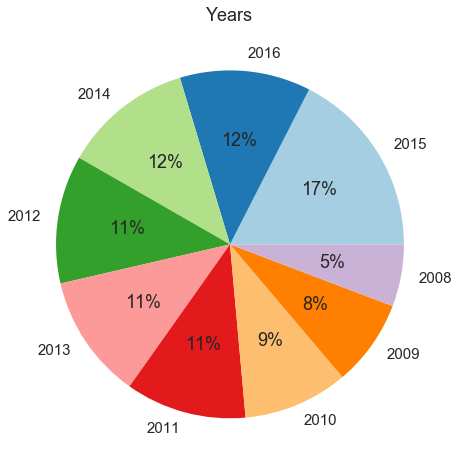

In [19]:
plot_diagram(train_df)

Из графика видно, что тренировочная выборка содержит публикации, начиная с 2008 года. Наибольшее количество публикаций соответствует 2015 году.

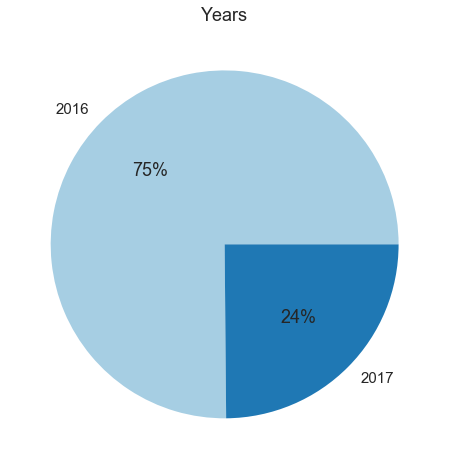

In [20]:
plot_diagram(test_df)

Тестовая выборка содержит публикации только 2016 и 2017 года. 

#### Посмотрим в каком месяце (и какого года) было больше всего публикаций?

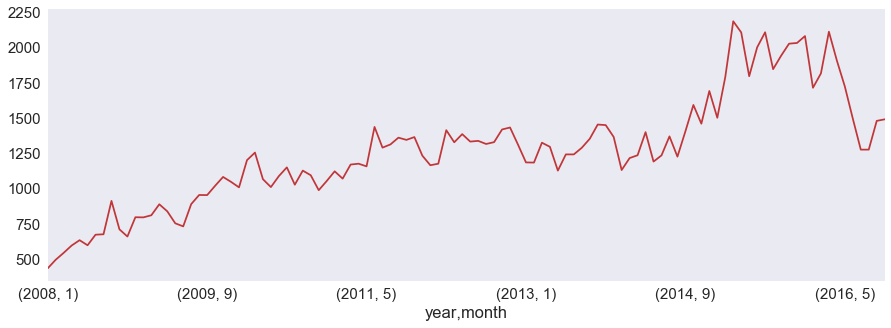

In [21]:
train_df.groupby(['year','month']).size().plot()

In [22]:
train_df['popular_month'] = [str(p)[:7] for p in train_df.published]

In [23]:
print(train_df.popular_month.value_counts()[:10])
popular_month = train_df.popular_month.value_counts().index[0]
print(popular_month)

2015-03    2189
2016-03    2115
2015-07    2111
2015-04    2110
2015-12    2084
2015-11    2035
2015-10    2030
2015-06    2004
2015-09    1944
2016-04    1910
Name: popular_month, dtype: int64
2015-03


Самым популярным месяцем был март 2015 года. Посмотрим на количество публикаций в этом месяцев в зависимости от дня:

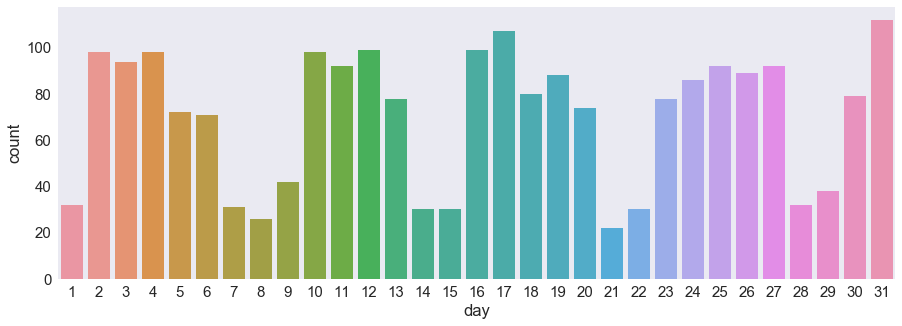

In [24]:
popular_month_df = train_df[train_df.popular_month == popular_month]
popular_month_df['day'] = [p.day for p in popular_month_df.published]

sns.countplot(x = 'day', data = popular_month_df);

Легко можем заметить сезонность в данных. В выходные и праздничные дни публикуется в разы меньше постов, чем в будние дни.

** Также сравним количество публикаций для разных доменов **

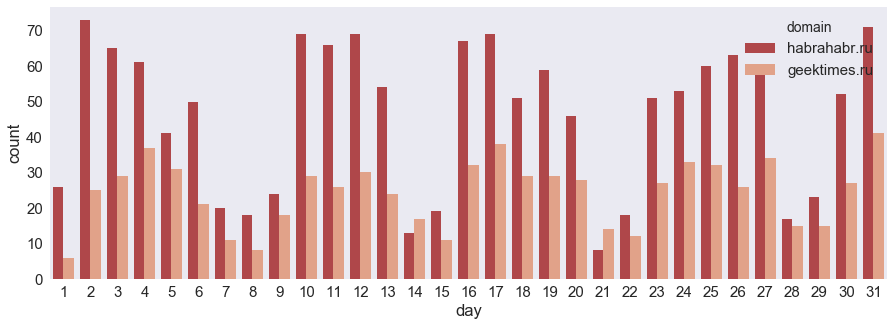

In [25]:
sns.countplot(x = 'day', hue = 'domain', data = popular_month_df);

Из графика видно, что количество публицкаций на habrahabr.ru больше, чем на geektimes.ru

Также посмотрим еще на зависимость количества комментариев от времени:

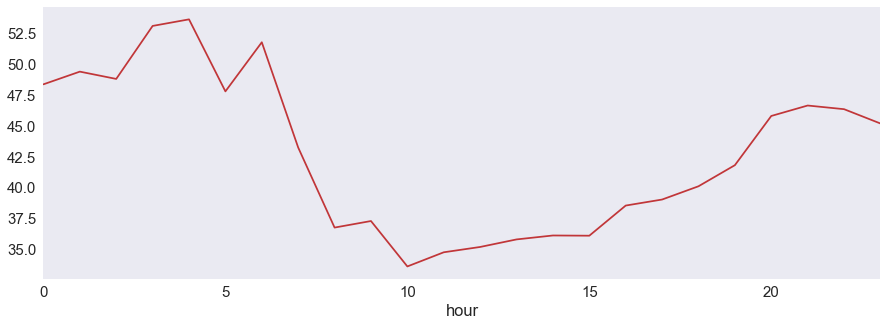

In [26]:
train_df.groupby('hour')['comments'].mean().plot()

Как ни странно, наибольшую активность пользователи проявляют в посты опубликованные в ночное время. Затем к началу рабочего дня активность резко падает и снова начинает расти при приближении времени к вечеру.

А также этот параметр для статьей, написанных на habrahabr.ru

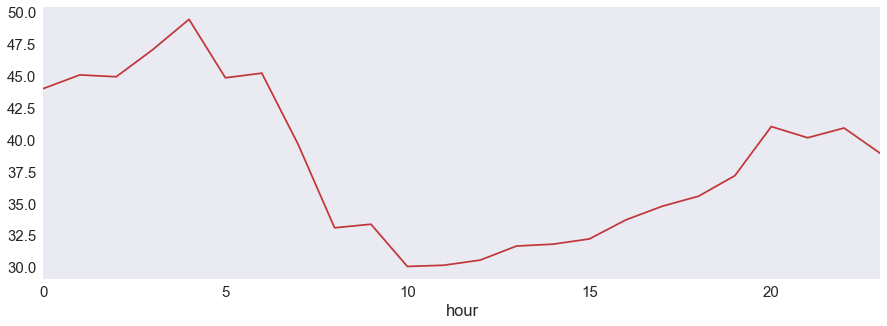

In [27]:
train_df[train_df['domain']=='habrahabr.ru'].groupby('hour')['comments'].mean().plot()

** Разбиение на train и test **

In [28]:
RANDOM_SEED = 88888

In [29]:
X = train_df.sample(n = train_df.shape[0], random_state = RANDOM_SEED).reset_index(drop = True)

In [30]:
y = X['favs_lognorm']
X = X.drop('favs_lognorm',  axis = 1)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35, random_state = 0)

** Обработка категориальных признаков **

In [33]:
vectorizer_for_title = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))

X_train_title = vectorizer_for_title.fit_transform(X_train['title'])
X_valid_title = vectorizer_for_title.transform(X_valid['title'])
X_test_title = vectorizer_for_title.transform(test_df['title'])

In [34]:
vectorizer_for_title_char = TfidfVectorizer(analyzer='char')

X_train_title_ch = vectorizer_for_title_char.fit_transform(X_train['title'])
X_valid_title_ch = vectorizer_for_title_char.transform(X_valid['title'])
X_test_title_ch = vectorizer_for_title_char.transform(test_df['title'])

In [35]:
vectorizer_dict = DictVectorizer()

X_train_category = vectorizer_dict.fit_transform(X_train.ix[:, categorial].T.to_dict().values())
X_valid_category = vectorizer_dict.transform(X_valid.ix[:, categorial].T.to_dict().values())
X_test_category = vectorizer_dict.transform(test_df.ix[:, categorial].T.to_dict().values())

** Соединение матриц **

In [36]:
X_train_ = scipy.sparse.hstack([X_train_title, X_train_title_ch, X_train_category])
X_valid_ = scipy.sparse.hstack([X_valid_title, X_valid_title_ch, X_valid_category])
X_test_ =  scipy.sparse.hstack([X_test_title, X_test_title_ch, X_test_category])

## Применение моделей

### Ridge

Для начала построим Ridge, линейную модель с l2-регуляризацией:

In [36]:
%%time
model_ridge = Ridge(alpha = 1.0, random_state = 1)
model_ridge.fit(X_train_, y_train)

Wall time: 8.11 s


In [37]:
train_preds_ridge = model_ridge.predict(X_train_)
valid_preds_ridge = model_ridge.predict(X_valid_)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds_ridge))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds_ridge))

Ошибка на трейне 0.0826199319182
Ошибка на тесте 0.581032537249


Нам удалось сразу получить довольно хорошие показатели по ключевой метрике на простой модели. 

Попробуем улучшить этот показатель обучив более сложные алгоритмы:

### DecisionTreeRegressor

In [51]:
from sklearn.tree import DecisionTreeRegressor

In [52]:
%%time
parameters = {'max_features' : ["sqrt", "log2", "auto"]}
dtr = GridSearchCV(DecisionTreeRegressor(), parameters, scoring = 'neg_mean_squared_error', n_jobs=-1)
dtr.fit(X_train_, y_train);

Wall time: 21min 31s


In [53]:
dtr.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [54]:
train_preds_dtr = dtr.predict(X_train_)
valid_preds_dtr = dtr.predict(X_valid_)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds_dtr))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds_dtr))

Ошибка на трейне 0.000378754155563
Ошибка на тесте 1.36055622877


Сразу легко заметить, что получившаяся модель переобучена. Мы получили очень низкое значение MSE на обучающей выборке, при этом ошибка на тестовой выборке получилась большой. Такую модель нельзя назвать качественной.

### RandomForestRegressor

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
%%time
parameters = {"max_features" : ["sqrt", "auto"]}
#"max_features" : ["sqrt", "log2", "auto"], "max_depth" : [8, 16, 32, None]
rfc = GridSearchCV(RandomForestRegressor(), parameters, scoring = 'neg_mean_squared_error', n_jobs=-1)
rfc.fit(X_train_, y_train);

Wall time: 2h 13min 2s


In [41]:
rfc.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [42]:
train_preds_rf = rfc.predict(X_train_)
valid_preds_rf = rfc.predict(X_valid_)

print('Ошибка на трейне',mean_squared_error(y_train, train_preds_rf))
print('Ошибка на тесте',mean_squared_error(y_valid, valid_preds_rf))

Ошибка на трейне 0.135503923966
Ошибка на тесте 0.771896964531


Мы получили довольно неплохой результат сопоставимый с результатом модели **Ridge**, однако получили куда большее время обучения модели по сравнению с моделью линейной регрессии, даже с учетом подбора гиперпараметров. 

### GradientBoostingRegressor

При попытке обучить и сделать предсказание с помощью модели **GradientBoostingRegressor** возникли сложности. 

Наши данные сохранены в форме *sparse matrix*, так как имеют очень высокую размерность и хранение такого объема данных не может себе позволить обычный компьютер:

In [73]:
print ("Количество строк:     {0:,}".format(X_train_.shape[0]).replace(',', ' '))
print ("Количество столбцов:  {0:,}".format(X_train_.shape[1]).replace(',', ' '))
print ("Количество элементов: {0:,}".format(X_train_.shape[0] * X_train_.shape[1]).replace(',', ' '))

Количество строк:     87 189
Количество столбцов:  153 982
Количество элементов: 13 425 536 598


Однако модель **GradientBoostingRegressor** не позволяет оперировать данными в формате *sparse matrix*, а для сохранения этих данных в обычный массив нам не хватает оперативной памяти.

В связи с этим у нас нет возможности использовать данную модель.

### Prophet

Для разнообразия нашего проекта попробуем использовать открытую библиотеку **Prophet**.

Данная библиотека была разработана для предсказания большого числа бизнес параметров. Главным ее достоинствоим является хорошее качество прогнозов, а также дает возможность изменять понятные обывателю параметры, не требующих хороших знаний в устройстве предсказательных моделей

Реализация библиотеки очень похожа на всем привычные библиотеки из *sklearn*. На первом этапе мы создаем модель, затем обучаем ее с помощью метода **fit** и после этого можем получить свой прогноз.

Однако конечно же библиотека имеет свои особенности. Так в метод **fit** мы передаем dataframe состоящий из всего двух колонок:
    - время, в формате date или datetime
    - числовой показатель, который мы хотим предсказать

Приведем данные к нужному формату:

In [50]:
habr_df = pd.read_csv('howpop_train.csv')
habr_df['published'] = pd.to_datetime(habr_df.published)
habr_df = habr_df[['published', 'favs_lognorm']]
habr_df.columns = ['ds', 'y']
habr_df.head()

,ds,y
0,2008-01-01 18:19:00,-1.344075
1,2008-01-01 18:30:00,-0.831946
2,2008-01-01 18:34:00,1.794023
3,2008-01-02 01:32:00,1.300050
4,2008-01-02 14:34:00,0.961094


In [51]:
habr_df.shape

(134137, 2)

Укажем количество наблюдений, которые мы будем использовать для оценки качества алгоритма и удалим их из обучающей выборки:

In [53]:
from fbprophet import Prophet
predictions = 300
train_df = habr_df[:-predictions] 

Обучим модель:

In [57]:
m = Prophet()
m.fit(train_df);

Создадим dataframe **future**, который содержит временные метки постов, на которых мы обучились, плюс валидационные наблюдения, и делаем предсказание:

In [71]:
future = habr_df[['ds']]
forecast = m.predict(future)

В библиотеке **Prophet** есть встроенные средства визуализации, которые позволяют оценить результат построенной модели.

Один из таких методов - это метод **plot_components**. Она дает нам возможность увидеть тренд, недельную сезонность и годовую сезонность. Это может дать нам новую и полезную информацию, на основании которой можно будет сделать какие-либо выводы. 

В нашем случае, например, отчетливо видно, что посты размещаемые по выходным дням обладают большей популярностью.

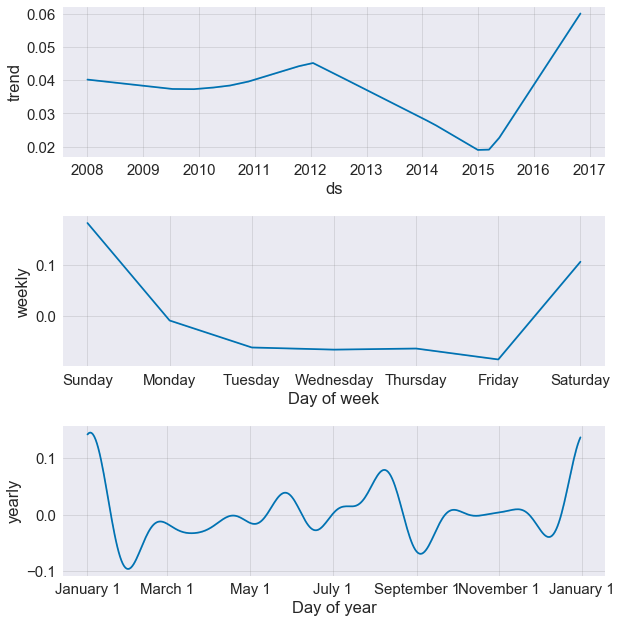

In [80]:
m.plot_components(forecast);

### Оценка качества модели

Теперь нам необходимо оценить качество построенной модели. Для этого мы должны рассчитать **MSE**, являющиеся нашей основной метрикой.

Для рассчета этого значения нам понадобятся: 

    - наблюдения (y)
    - прогноз (y_hat)

Прежде чем продолжить, нам нужно объединить **forecast** с нашими исходными наблюдениями.

In [92]:
cmp_df = forecast.set_index('ds')[['yhat']].join(habr_df.set_index('ds'))

In [94]:
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']

print ('MAE: ', np.mean(abs(cmp_df[-predictions:]['e'])))
print('MSE: ', mean_squared_error(cmp_df.y, cmp_df.yhat))

MAE:  0.7641134894416721
MSE:  1.01994210029


В нашем случае использование данного метода прогнозирования изначально было не совсем оправдано. Данная модель принимает во внимание только время публикования поста на сайте, однако в нашем анализе очевидным является то, что это далеко не главный и единсвенный признак, по которому можно строить предположение. Так как большую роль будет играть содержание публикуемого поста. 

Получившиеся результаты модели подтверждают это предположение, модель не показала лучший результат **MSE** в этой работе, однако было интересно попробовать нечто новое для себя. Возможно, что при ее использовании в другой задаче она проявит себя куда лучше остальных.

### Итоги работы

В данной работе мы попались предсказать количество звездочек у статьи, а если говорить точнее, то долю статей, у которых звездочек меньше, чем у текущей. Ознакомившись с данными с помощью визуализации и предобработав их для создания обучающей и тестовой выборки, мы перешли к обучению моделей:

    - Ridge
    - DecisionTreeRegressor
    - RandomForestRegressor
    - GradientBoostingRegressor
    - Prophet

Отдельным разочарованием стала модель **GradientBoostingRegressor**, так как из-за технических особенностей в ее реализации мы даже не смогли сделать по ней предсказание. 

Наилучший результат показала модель линейной регрессии с l2 регуляризаций **Ridge**. Она обучилась заметно быстрее остальных моделей за счет простоты алгоритма, а также показала наилучший результат, который в нашей работе измерялся метрикой **Mean Squared Error**.

Поэтому для решения этой задачи лучшим алгоритмом однозначно стал **Ridge** с результатом **MSE = 0.58** на валидационной выборке.